## <center> Projet Nº 9 </center>
### <center> Prédisez la demande en électricité </center>

**Vous êtes employé chez Enercoop, société coopérative qui s'est développée grâce à la libéralisation du marché de l’électricité en France. Elle est spécialisée dans les énergies renouvelables. La plupart de ces énergies renouvelables est cependant intermittente, il est donc difficile de prévoir les capacités de production d'électricité. De plus, la demande en électricité des utilisateurs varie au cours du temps, et dépend de paramètres comme la météo (température, luminosité, etc.)
Tout le challenge est de mettre en adéquation l'offre et la demande !**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.tsatools import detrend
import scipy.stats as st
from scipy.stats import norm, shapiro
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings     
import datetime
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima
import statsmodels.api as sm
from scipy import stats
import statsmodels.formula.api
import pingouin as pg
from math import sqrt
from sklearn.model_selection import TimeSeriesSplit
warnings.filterwarnings('ignore')

## Importation des dataframes

In [2]:
conso = pd.read_table("./data/energie.xls", encoding='latin-1')
dju = pd.read_excel("./data/dju.xlsx", header=11)

## Nettayage des Dataframes

In [3]:
df = conso.loc[conso['Territoire'] == 'France'].reset_index(drop=True)\
               .sort_values('Mois')[['Mois', 'Consommation totale']]

df.columns = ['date', 'consommation']
df['date'] = pd.to_datetime(df['date'])
#df.head()

######################################################## DJU ####################################################
# On suprime la colonne Total
dju = dju.drop('Total', axis=1)
# Renomme les colonnes
dju.columns = ['annee', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
# On cree la colonne mois
dju = pd.melt(dju, id_vars='annee', var_name='mois', value_name='dju')
# Converstion en datetime
dju['date'] = pd.to_datetime(dju['annee']\
                            .astype(str) + '-' + dju['mois'], format='%Y-%m')

df_dju = dju.drop(['annee', 'mois'], axis=1)


#################################### Dataframe final #############################################################
# creation du dataframe final
df_final = pd.merge(df, df_dju, how='inner')
df_final = df_final.set_index('date').sort_index()
df_final = df_final['2012-01-01':'2021-09-01'].resample('M').sum()
df_final.head() 

,consommation,dju
date,,
2012-01-31,51086,361.5
2012-02-29,54476,468.6
2012-03-31,43156,241.4
2012-04-30,40176,254.3
2012-05-31,35257,104.6


## Analyse de Dataframes

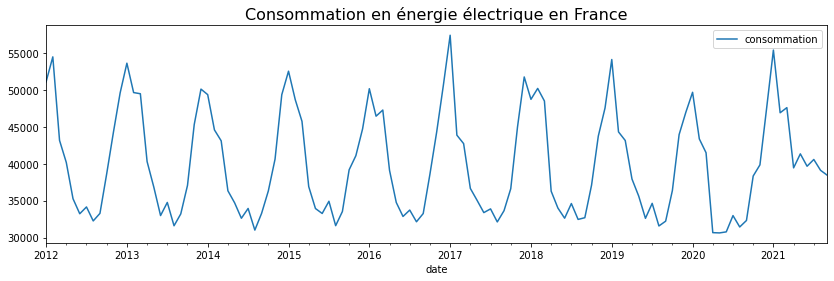

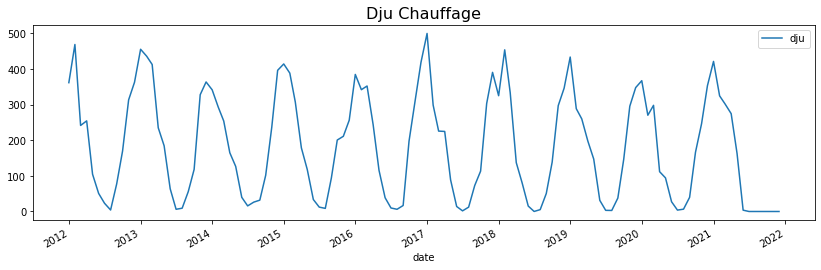

In [4]:
# Représentation graphique de la consommation d'énergie électrique
df.plot(x="date", y="consommation", figsize=(14,4))
plt.title('Consommation en énergie électrique en France', size=16)
plt.show()
# Représentation graphique de la consommation dju chauffage
df_dju = df_dju[df_dju['date'] >= '2012-01-01']
df_dju.plot(x="date", y="dju", figsize=(14,4))
plt.title('Dju Chauffage', size=16)
plt.show()

**Observation :**
- Dans la série temporelle ci-dessus on peut identifier des cycles assez réguliers au cours du temps et de même amplitude. 

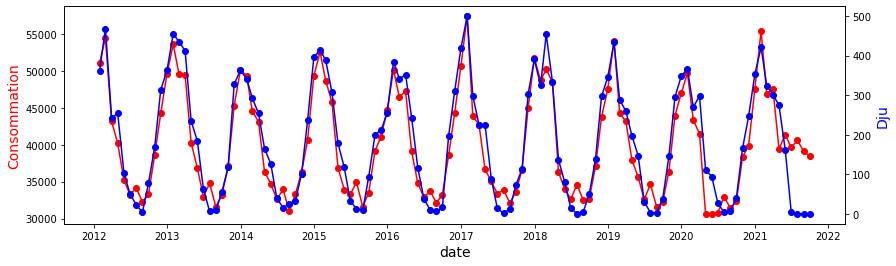

In [5]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(14,4))
# make a plot
ax.plot(df_final['consommation'], color="red", marker="o")
# set x-axis label
ax.set_xlabel("date",fontsize=14)
# set y-axis label
ax.set_ylabel("Consommation",color="red",fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(df_final["dju"],color="blue",marker="o")
ax2.set_ylabel("Dju",color="blue",fontsize=14)
plt.show()
# save the plot as a file
#fig.savefig('two_different_y_axis_for_single_python_plot_with_twinx.jpg',
#            format='jpeg',
#            dpi=100,
#            bbox_inches='tight')

**Observation :**
- Les 2 courbes semblent suivre la même saisonnalité ce qui indique bien que les variations de la courbe de consommation d'énergie sont effectivement globalement liées aux écarts de températures.

> ### Répartition des données et tests de normalité cosommation et dju

**Répartition des données : consommation électrique**

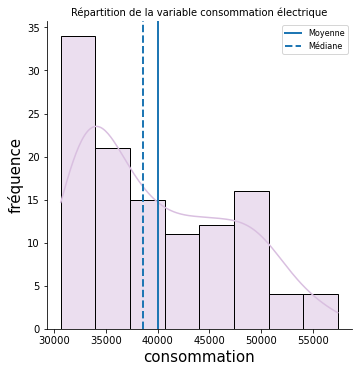

In [6]:
plt.rcParams["figure.figsize"] = (10,8)

sns.displot(df_final["consommation"],
                     kde=True,
                  color='#D9BFE0')

plt.axvline(x=df_final["consommation"].mean(), label='Moyenne', linestyle='-', linewidth=2)
plt.axvline(x=df_final["consommation"].median(), label='Médiane', linestyle='--', linewidth=2)
plt.xlabel('consommation', size=15)
plt.ylabel('fréquence', size=15)
plt.title('Répartition de la variable consommation électrique', size=10)
plt.legend(prop={'size':8})

#plt.savefig('répartition consommation.jpg', dpi=1200, bbox_inches='tight')

plt.show()

In [7]:
#Test de shapiro
print('Test de Shapiro est : {}'.format(st.shapiro(df_final['consommation'])[1]))

Test de Shapiro est : 4.684013219957706e-06


**Observation :**
- La variable consommation ne suive pas une distribution normal. 
- On a obtenu un P-value inférieur à 5%.

**Test de normalité : DJU**

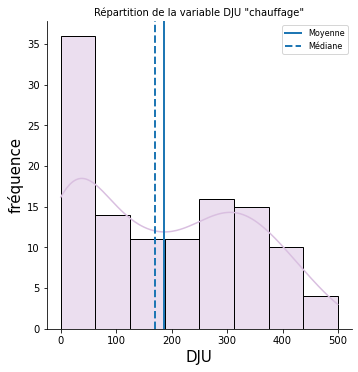

In [8]:
plt.rcParams["figure.figsize"] = (10,8)

sns.displot(df_final["dju"],
                     kde=True,
                  color='#D9BFE0')

plt.axvline(x=df_final["dju"].mean(), label='Moyenne', linestyle='-', linewidth=2)
plt.axvline(x=df_final["dju"].median(), label='Médiane', linestyle='--', linewidth=2)
plt.xlabel('DJU', size=15)
plt.ylabel('fréquence', size=15)
plt.title('Répartition de la variable DJU "chauffage"', size=10)
plt.legend(prop={'size':8})
#plt.savefig('repar_conso_dju.jpg', dpi=1200, bbox_inches='tight')

plt.show()

In [9]:
#Test de shapiro
print('Test de Shapiro est : {}'.format(st.shapiro(df_final['dju'])[1]))

Test de Shapiro est : 2.428822654110263e-06


**Observation :**
- La variable dju ne suive pas une distribution normal. 
- On a obtenu un P-value inférieur à 5%

## <center> Mission 1 </center>

1. - ***Corrigez les données de consommation mensuelles de l'effet température (dues au chauffage électrique) en utilisant une régression linéaire.***

In [10]:
RL = statsmodels.formula.api.ols('consommation ~ dju', data=df_final).fit()
RL.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           consommation   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     852.3
Date:                Wed, 16 Mar 2022   Prob (F-statistic):           5.22e-55
Time:                        10:46:23   Log-Likelihood:                -1077.3
No. Observations:                 117   AIC:                             2159.
Df Residuals:                     115   BIC:                             2164.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.167e+04    363.388     87.151      0.000    3.09e+04    3.24e+04
dju           44.5661      1.527     29.195      0.000      41.542      47.590
==============================================================================
Omnibus:                       23.101   Durbin-Watson:                   1.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.810
Skew:                           0.874   Prob(JB):                     2.27e-09
Kurtosis:                       5.260   Cond. No.                         384.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Observation :**
- Ici, le  est de l'ordre de 0.88, ce qui est relativement élévé et au vu de la représentation graphique de notre droite de régression, cela nous indique que le modèle est bon. La variable "dju" est également statistiquement significative au niveau de test 5%, sa **P-value étant de 0.**

In [11]:
print('Ce modèle explique', round(100*RL.rsquared, 2), '% de la variance de la variable "Consommation"')

Ce modèle explique 88.11 % de la variance de la variable "Consommation"


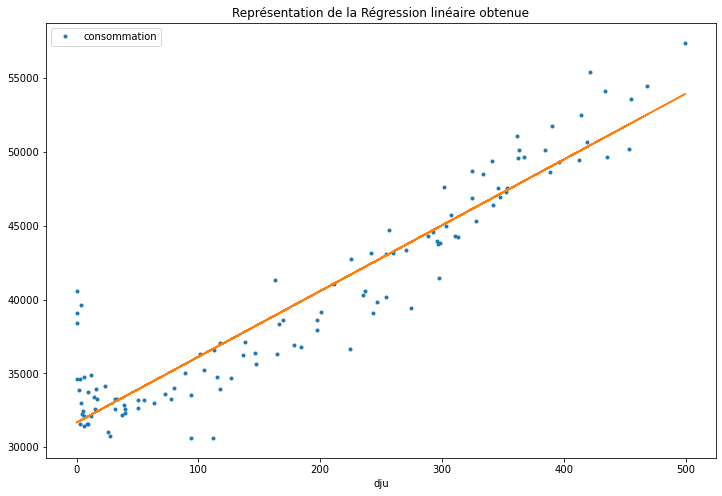

In [12]:
#Représentation de la Régression linéaire obtenue
plt.rcParams["figure.figsize"] = (12,8)
df_final.plot(x='dju', y='consommation', style='.')
plt.plot(df_final['dju'], RL.predict(sm.add_constant(df_final['dju'])))
plt.title('Représentation de la Régression linéaire obtenue')
#plt.savefig('relation_line.jpg', dpi=1200, bbox_inches='tight')
plt.show()

In [13]:
pearson = st.pearsonr(df_final["dju"], df_final["consommation"])[0]
p_value = st.pearsonr(df_final["dju"], df_final["consommation"])[1]
print("Coefficient de corrélation de Pearson :", pearson)
print("p-value :", p_value)

Coefficient de corrélation de Pearson : 0.9386776370357779
p-value : 5.215414849495032e-55


**Observation :**
- Les points suivent la droite de régression et couvrent bien l’étendue entière des valeurs. On constate donc **une relation forte** entre nos deux variables, ce qui est confirmé par le coefficient de Pearson proche de 1.
- Avec une P-value significative donc le modèle est cohérent.

### Test de normalité des résidus :

***L’inférence dans la régression linéaire repose sur l’hypothèse de normalité des erreurs. Une première vérification importante consiste à vérifier la compatibilité des résidus (l’erreur observée sur l’échantillon).***

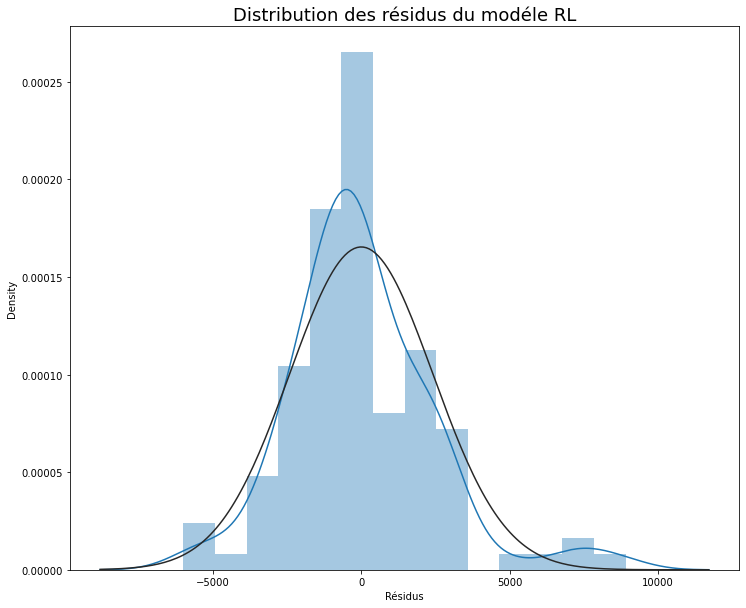

In [14]:
#Distribution des résidus
# Histogram
plt.rcParams["figure.figsize"] = (12,8)
fig = plt.figure(figsize=(12, 10))
ax = sns.distplot(RL.resid, fit=norm)
plt.xlabel('Résidus')
plt.title('Distribution des résidus du modéle RL', fontsize=18)
#plt.savefig('dist_resi.jpg', dpi=1200, bbox_inches='tight')
plt.show()

**Observation :**
- On remarque donc que la distribution des résidus semble centrée et suivent une loi gaussienne. Nous allons réaliser un test de Shapiro-Wilk pour confirmer ce dernier point.

In [15]:
shapiro_t = shapiro(RL.resid)
shapiro_t.pvalue # suit une loi normale

7.782274042256176e-05

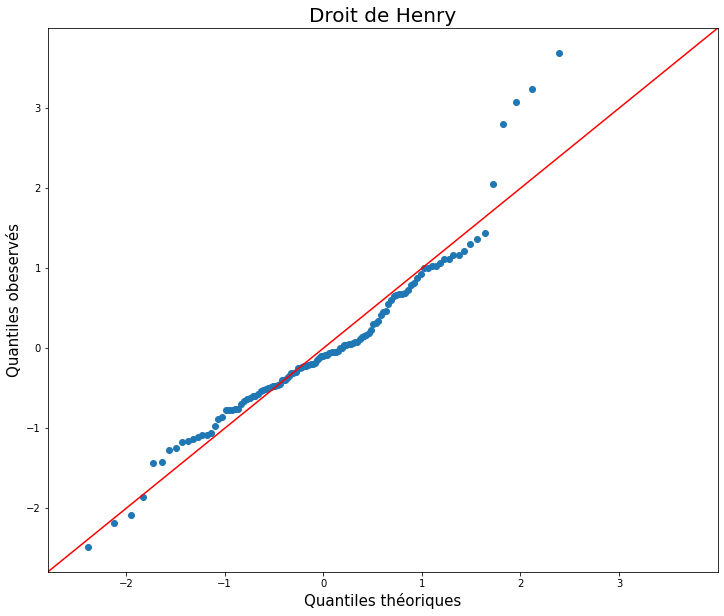

In [16]:
# Vérification du modèle - Analyse des résidus
def residus(Model, non, color, ax):
    sm.qqplot(Model.resid, ax=ax, line='45', fit=True, color=color)
    ax.set_title('Droit de Henry', fontsize=20)
    ax.set_xlabel('Quantiles théoriques', fontsize=15)
    ax.set_ylabel("Quantiles obeservés", fontsize=15)
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
residus(RL, 'RL', 'brown', ax)
#plt.savefig('plot_repar_conso_dju.jpg', dpi=1200, bbox_inches='tight')
plt.show()

**Observation :**
- La P-value est ici non significative au niveau de test 5%. **Les résidus suivent une loi normal** comme nous l'observons sur le QQplot.

> #### Correction de l'effet température grâce à une régression linéaire (chauffage)

In [17]:
#Coefficient de régression linéaire
RL.params['dju']

44.566090447030994

In [18]:
#Calcul de la correction : l'effet DJU est retranché à la consommation totale
df_final['conso_corri'] = df_final['consommation'] - df_final['dju'] * RL.params['dju']

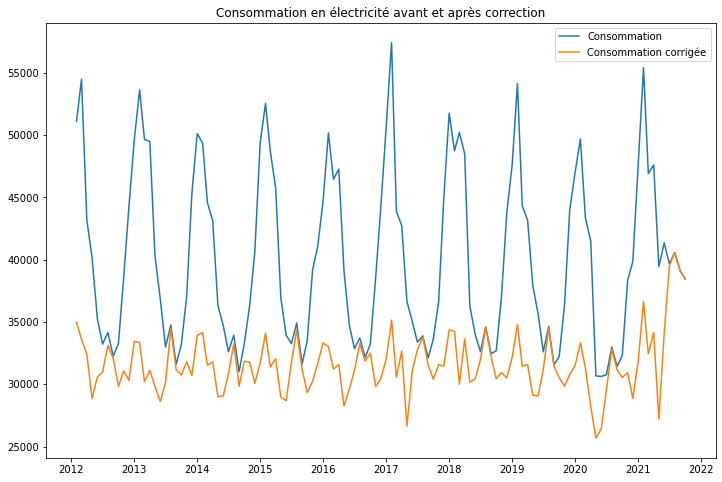

In [19]:
#Visualisation de la consommation en électricité avant et après correction
plt.plot(df_final['consommation'], label='Consommation')
plt.plot(df_final['conso_corri'], label='Consommation corrigée')
plt.title('Consommation en électricité avant et après correction')

plt.legend()
#plt.savefig('conso_corre.jpg', dpi=1200, bbox_inches='tight')
plt.show()

**Observation :**
- On voit ici clairement l'impact des températures sur les consommation d'énergie au niveau national. Il existe encore sur cette série temporelle corrigée un fort impact saisonnier.

## <center> Mission 2 </center>

2. - ***Effectuez une désaisonnalisation de la consommation que vous aurez obtenue après correction, grâce aux moyennes mobiles.***

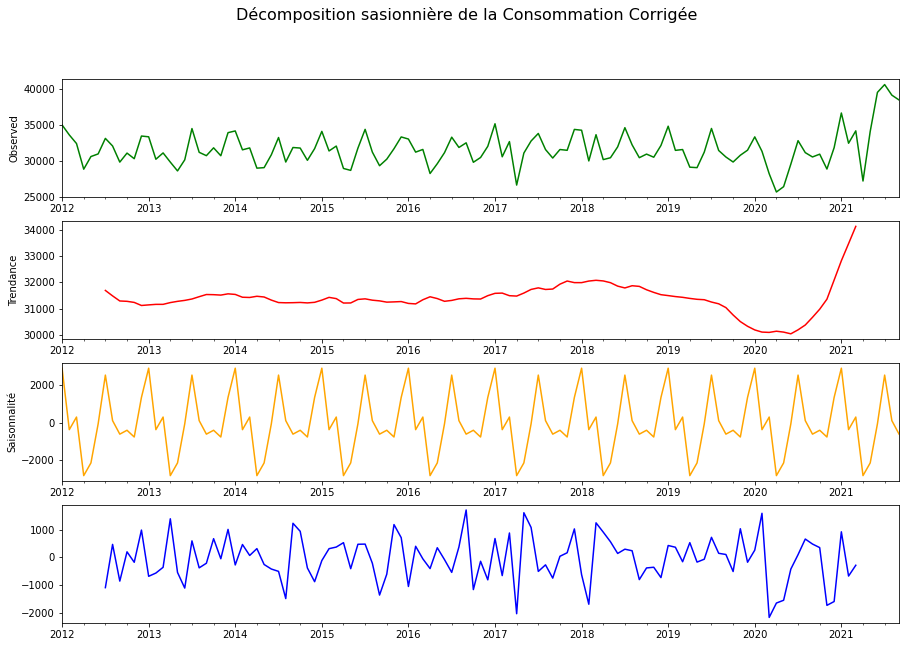

In [20]:
# Décomposition saisonnère
ds = seasonal_decompose(df_final['conso_corri'], model='additive')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10))
ds.observed.plot(ax=ax1, color='green') # Valeur observées
ds.trend.plot(ax=ax2, color='red') # Tendance
ds.seasonal.plot(ax=ax3, color='orange') # Saisonnalité
ds.resid.plot(ax=ax4, color='blue') # Résidus

ax1.set_ylabel('Observed')
ax2.set_ylabel('Trendance')
ax3.set_ylabel('Saisonnalité')
ax4.set_label('Résidual')
ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
ax4.set_xlabel('')
plt.suptitle('Décomposition sasionnière de la Consommation Corrigée', fontsize=16)
#plt.savefig('decompo.jpg', dpi=1200, bbox_inches='tight')
plt.show()

In [21]:
#Différence avec la saisonnalité pour obtenir une série temporelle hors impact saisonnier.
df_final['Consommation_désaisonnalisée'] = df_final['conso_corri'] - ds.seasonal

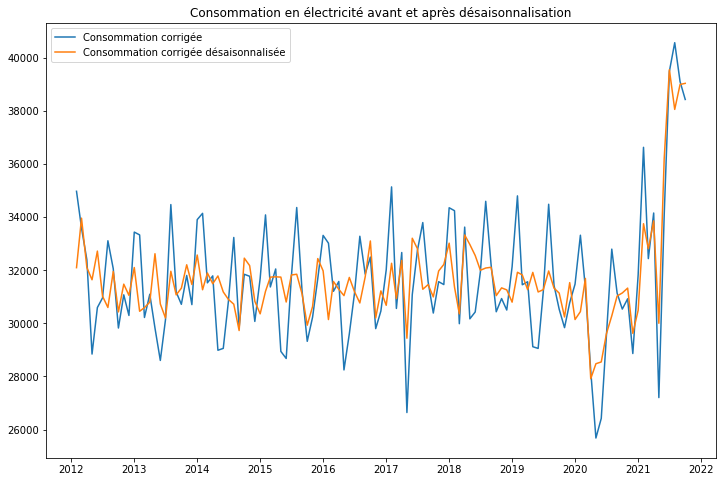

In [22]:
#Visualisation de la consommation en électricité avant et après désaisonnalisation
plt.plot(df_final['conso_corri'], label='Consommation corrigée')
plt.plot(df_final['Consommation_désaisonnalisée'], label='Consommation corrigée désaisonnalisée')
plt.title('Consommation en électricité avant et après désaisonnalisation')

plt.legend()
#plt.savefig('conso_desai.jpg', dpi=1200, bbox_inches='tight')
plt.show()

**Observation :**
- Le signal ressort corrigé et désaisonnalisé.

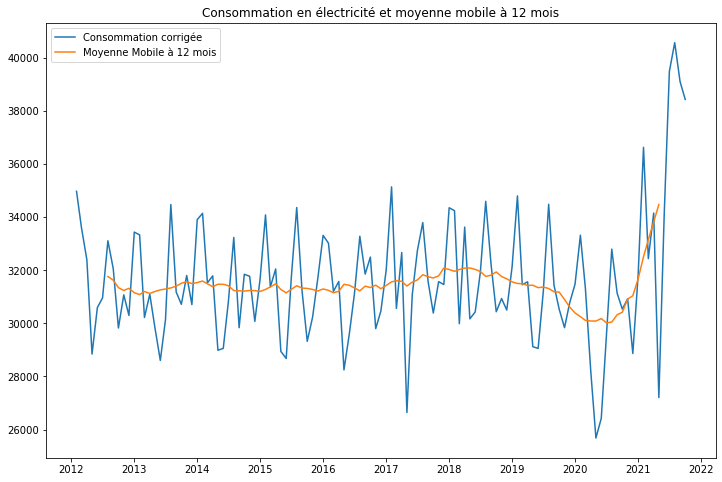

In [23]:
#Visualisation de la consommation en électricité avec moyenne mobile à 12 mois
plt.plot(df_final['conso_corri'], label='Consommation corrigée')
plt.plot(df_final['conso_corri'].rolling(12, center=True).mean(), label='Moyenne Mobile à 12 mois')


plt.title('Consommation en électricité et moyenne mobile à 12 mois')

plt.legend()
#plt.savefig('moyenmo.jpg', dpi=1200, bbox_inches='tight')
plt.show()

**Observation :**
- Le moyenne mobile à 12 mois affichée ci-dessus est représentative d'un signal sans tendance, constant sur le timeframe.

## <center>Mission 3</center>

3. - Effectuez une prévision de la consommation (corrigée de l'effet température) sur un an, en utilisant la méthode de Holt Winters (lissage exponentiel) puis la méthode SARIMA sur la série temporelle.

1. A l'aide de la méthode de Holt-Winters

La méthode de Holt-Winters génère des valeurs lissées de façon exponentielle pour le niveau, la tendance et l'ajustement saisonnier de la série temporelle. Cette méthode convient pour les séries temporelles dont la saisonnalité et la tendance restent stables dans le temps.

> **On va separer les données avec 'Timeseriessplit' de sklearn pour avoir notre train et test dataset**
- Les données seront separer en 3 doissier differents pour pouvoir les comparers. 

In [24]:
# On va utiliser timeseriessplit pour separé le dataset
# Nombre de split 

tscv = TimeSeriesSplit(n_splits=3)
tscv.split(df_final)

# On onbserve les observation dans le train et test
i=2
for train, test in tscv.split(df_final):
    i=i+1
    print ("Nombre des observations dans train%s=%s" % (i, len(train)))
    print ("Nombre des observations dans test%s=%s" % (i, len(test)))

Nombre des observations dans train3=30
Nombre des observations dans test3=29
Nombre des observations dans train4=59
Nombre des observations dans test4=29
Nombre des observations dans train5=88
Nombre des observations dans test5=29


In [25]:
# On split par apport aux observations
train1, test1 = df_final.iloc[:30, 2], df_final.iloc[30:59, 2]
train2, test2 = df_final.iloc[:59, 2], df_final.iloc[59:88, 2]
train3, test3 = df_final.iloc[:88, 2], df_final.iloc[88:117, 2]

- ***Le train1 contient les années de 2012-01-31 au 2014-06-30 et le test1 du 2014-07-31 au 2016-11-30***
- ***Le train2 contient les années de 2012-01-31 au 2016-11-30 et les test2 du 2016-12-31 au 2019-04-30***
- ***Le train3 contient les années de 2012-01-31 au 2019-04-30 et le test3 du 2019-05-31 au 2021-09-30***
> On fait cette separation compe tenu des forte variation de la consommation d'electricité (**hause et baise**) pendant les années 2020 et 2021.

> Première modéle

In [26]:
# Première modèle 
model1 = ExponentialSmoothing(train1, seasonal='add', seasonal_periods=12).fit(optimized=True)
pred1 = model1.predict(start=test1.index[0], end=test1.index[-1])
RMSE1_H =round(sqrt(mean_squared_error(test1, pred1)),2)
MAPE1_H = np.mean(np.abs((test1 - pred1) / test1)) * 100

print ("RMSE1_H:", RMSE1_H)
print ("MAPE1_H:", MAPE1_H)

RMSE1_H: 1031.94
MAPE1_H: 2.55288405198372


**Observation :**
- Le première modèle a obtenu une **RMSE de 1053.53** et une **MAPE de 2.65**.

> Deuxieème modèle

In [27]:
# Deuxeème modèle 
model2 = ExponentialSmoothing(train2, seasonal='add', seasonal_periods=12).fit()
pred2 = model2.predict(start=test2.index[0], end=test2.index[-1])
RMSE2_H = round(sqrt(mean_squared_error(test2, pred2)),2)
MAPE2_H = np.mean(np.abs((test2 - pred2) / test2)) * 100

print ("RMSE2_H:", RMSE2_H)
print ("MAPE2_H:", MAPE2_H)

RMSE2_H: 1074.05
MAPE2_H: 2.8207704421796915


**Observation :**
- Le deuxeème modèle a obtenu une **RMSE de 1149.55** et une **MAPE de 3.08**.

> Troisème modèle

In [28]:
# Troisième modèle
model3 = ExponentialSmoothing(train3, seasonal='add', seasonal_periods=12, use_boxcox=True).fit()
pred3 = model3.predict(start=test3.index[0], end=test3.index[-1])
RMSE3_H = round(sqrt(mean_squared_error(test3, pred3)),2)
MAPE3_H = np.mean(np.abs((test3 - pred3) / test3)) * 100

print ("RMSE3_H:", RMSE3_H)
print ("MAPE3_H:", MAPE3_H)

RMSE3_H: 3293.48
MAPE3_H: 6.5066631303177065


**Observation :**
- Le troisième modèle a obtenu une **RMSE de 3293.48** et une **MAPE de 6.51**.

**Observation :**

- On observe que le meilleur modèle est le modèle 1 avec une **RMSE de 1031,94 et MAPE de 2,55**, suivi par le modèle 2.


In [29]:
# On va calculer la moyenne de MAPE des 3 modèls
mape_mean = round((MAPE1_H + MAPE2_H + MAPE3_H)/3, 2)
mape_mean

3.96

**Observation :**
- On obtient un erreur absolue moyenne en pourcentage égale à 3,42% avec le modèle Holt-Winters

### Prediction de la demande en électricité sur les 12 prochain mois méthode Holt-Winters

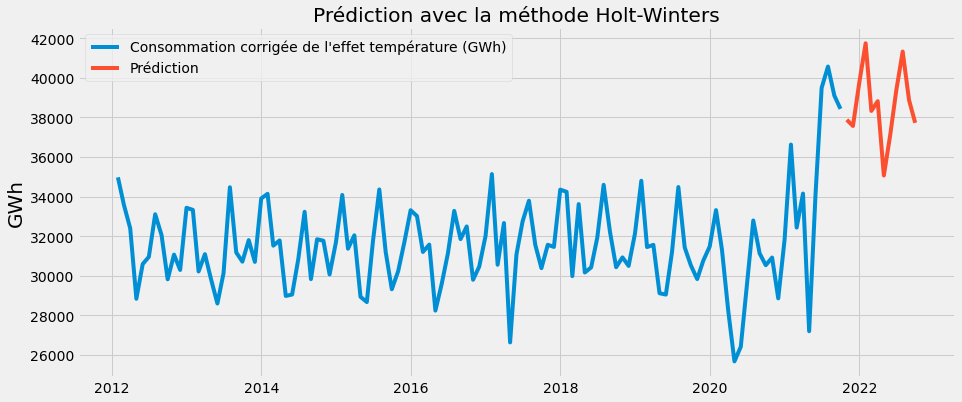

In [30]:
%matplotlib inline
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 14,8
# Model 
model = ExponentialSmoothing(df_final['conso_corri'],  seasonal='add', seasonal_periods=12).fit()
pred = model.predict(start=test3.index[0], end=test3.index[1])
# Prediction
#hw1_pred = model.forecast(12)
pred = model.forecast(12)

# Graphique de prédiction
plt.figure(figsize=(14,6))
plt.plot(df_final['conso_corri'], label="Consommation corrigée de l'effet température (GWh)")
plt.plot(pred, label='Prédiction')
plt.title('Prédiction avec la méthode Holt-Winters')
plt.ylabel("GWh", fontsize=20)
plt.legend()
#plt.savefig('pred_holt.jpg', dpi=1200, bbox_inches='tight')
plt.show()

### 3. 1.1 **Analyse à postériori des 3 modèles**

#### Analyse à postériori modèle I

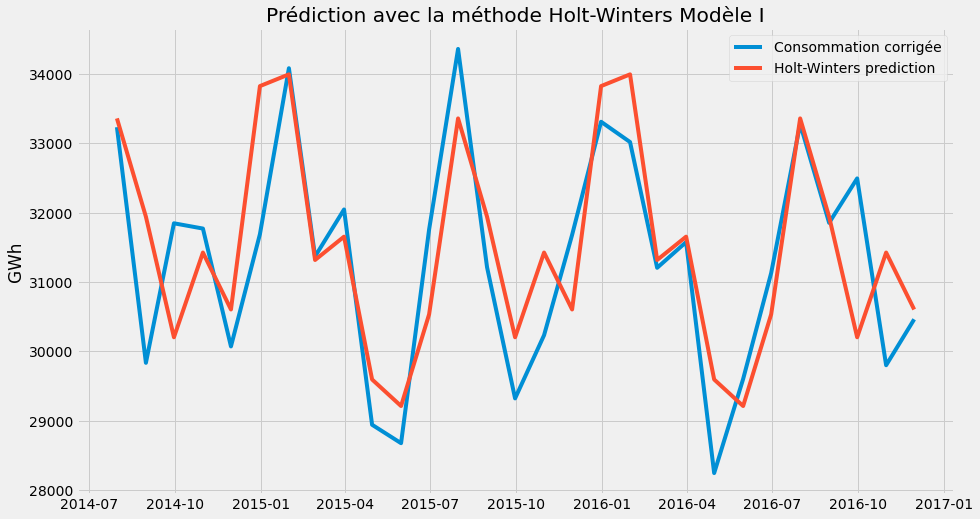

In [31]:
# Graphique modèle 1
plt.plot(test1.index, test1, label='Consommation corrigée')
plt.plot(pred1.index, pred1, label='Holt-Winters prediction')
plt.legend(loc='best')
plt.xlabel("")
plt.ylabel("GWh")
plt.title("Prédiction avec la méthode Holt-Winters Modèle I")
#plt.savefig('HW_model_1.jpg', dpi=1200, bbox_inches='tight')
plt.show()

**Observation :**
- La prédiction pour 2014-2017 avec la méthode de Holt Winters est relativement fidèle aux données réelles. La saisonnalité et la tendance sont représentatives.

#### Analyse à postériori modèle II

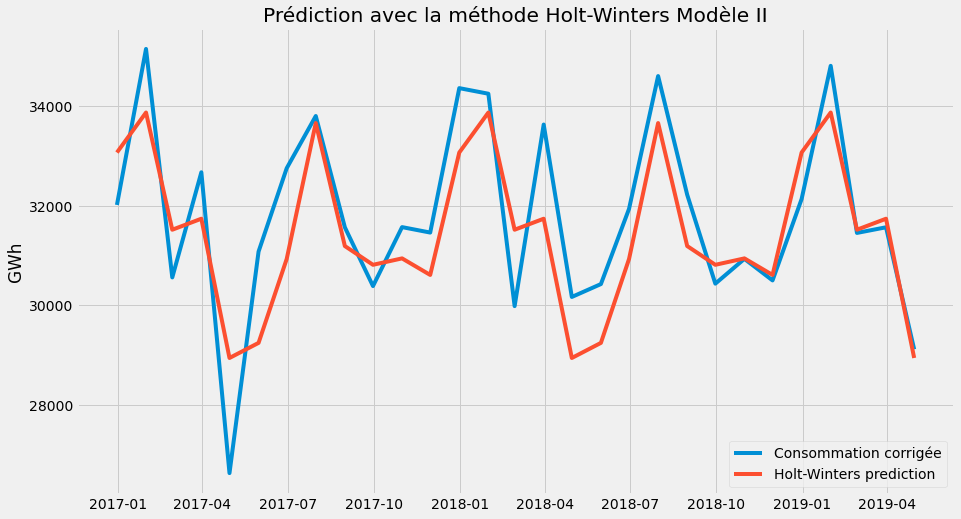

In [32]:
# Graphique modèle 2
plt.plot(test2.index, test2, label='Consommation corrigée')
plt.plot(pred2.index, pred2, label='Holt-Winters prediction')
plt.legend(loc='best')
plt.xlabel("")
plt.ylabel("GWh")
plt.title("Prédiction avec la méthode Holt-Winters Modèle II")
#plt.savefig('HW_model_2.jpg', dpi=1200, bbox_inches='tight')
plt.show()

**Observation :**
- La prédiction pour 2017-2019 avec la méthode de Holt Winters est relativement fidèle aux données réelles. La saisonnalité et la tendance sont représentatives.

#### Analyse à postériori modèle III



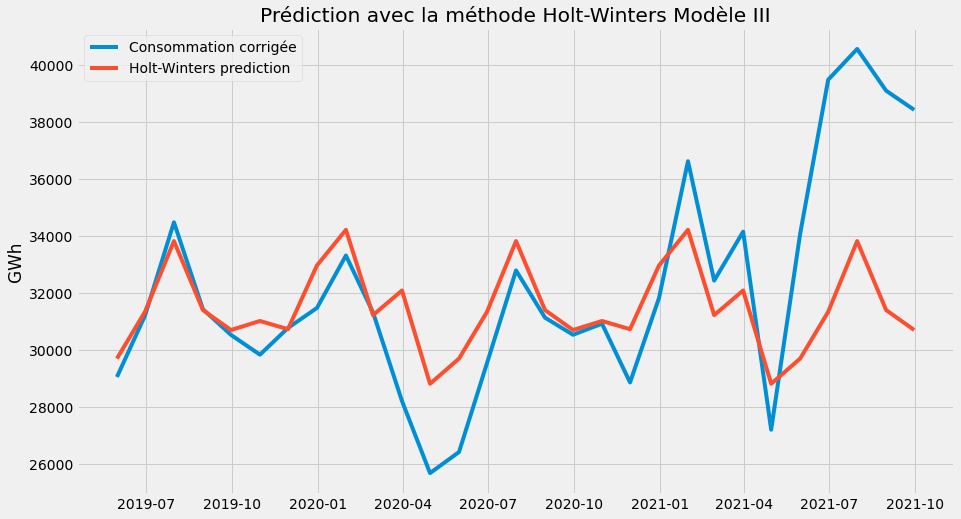

In [33]:
# Graphique modèle 3
plt.plot(test3.index, test3, label='Consommation corrigée')
plt.plot(pred3.index, pred3, label='Holt-Winters prediction')
plt.legend(loc='best')
plt.xlabel("")
plt.ylabel("GWh")
plt.title("Prédiction avec la méthode Holt-Winters Modèle III")
#plt.savefig('HW_model_3.jpg', dpi=1200, bbox_inches='tight')
plt.show()

**Observation :**
- La prédiction pour 2019-2021 avec la méthode de Holt Winters n'est pas fidèle aux données réelles. La prédiction ne suive pas la forte hausse et baisse.

2. Méthode SARIMA

Les modèles SARIMA (Seasonnal AutoRegressive Integrated Moving Average) permettent de modéliser des séries qui présentent une saisonnalité, comme c'est le cas pour notre dataset.

In [34]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Test de Dickey–Fuller 
        avec Autocorrélogrammes ACF et PACF
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

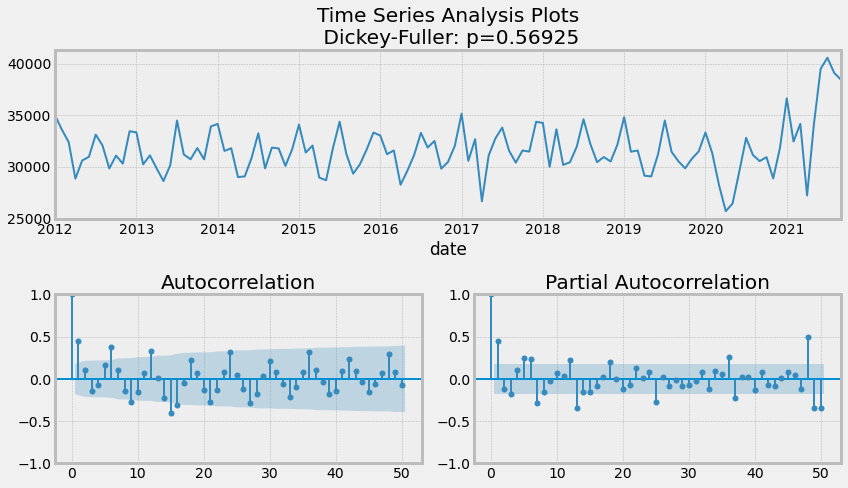

In [35]:
#Test de Dickey–Fuller avec Autocorrélogrammes ACF et PACF
tsplot(df_final['conso_corri'], lags=50)
#plt.savefig('sami1.jpg', dpi=1200, bbox_inches='tight')

**Observation :**

- La sortie ACF présente une décroissance lente vers 0, ce qui traduit un problème de non-stationnarité. Confirmation également par le test de Dickey-Fuller portant pour hypothèse nulle la non-stationnarité de la série, ne pouvant pas être rejetée. On effectue donc une première différenciation.



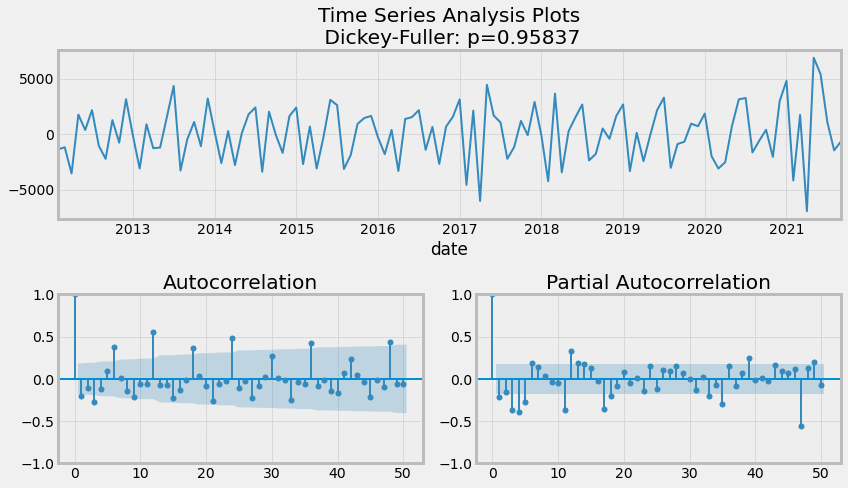

In [36]:
#Première différenciation d'ordre 1 par la méthode .shift()
df_diff1 = df_final['conso_corri'] - df_final['conso_corri'].shift(1)
tsplot(df_diff1[1:], lags=50)
#plt.savefig('sami2.jpg', dpi=1200, bbox_inches='tight')

**Observation :**
- On constate des pics tout les 6 mois, qui décroissent lentement. On effectue une différenciation de 12

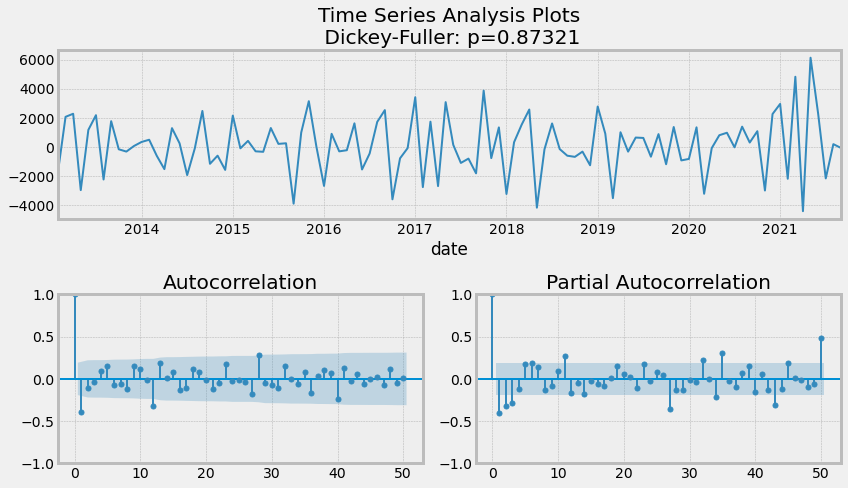

In [37]:
# Seconde différenciation d'ordre 12 
df_diff1_12 = df_diff1 - df_diff1.shift(12)
tsplot(df_diff1_12[13:], lags=50)
#plt.savefig('sami3.jpg', dpi=1200, bbox_inches='tight')

**Observation :**
- Cette fois-ci les résultats sont satisfaisants, nous pouvons nous appuyer sur les autocorrélogrammes simple et partiels estimés.

> 3. 2-1 Optimisation des paramètres

In [38]:
stepwise_model = auto_arima(df_final.conso_corri, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1861.815, Time=0.47 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1872.024, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1866.259, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1862.239, Time=0.13 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1868.151, Time=0.14 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=1856.555, Time=0.33 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=1864.783, Time=0.38 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=1857.300, Time=0.71 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=1857.202, Time=0.93 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1855.252, Time=0.49 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1855.350, Time=0.33 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=1856.473, Time=0.29 sec
 ARIMA(2,1,1)(0,1,2)[12]             : AIC=1855.649, Time=0.94 sec
 ARIMA(1,1,2)(0,1,2)[12]             : AIC=1856.054, Time=0.61 sec
 ARIMA(0,1,0)(0,1,2

In [39]:
SARI = sm.tsa.statespace.SARIMAX(np.asarray(df_final.conso_corri), order=(0,1,2),            
                                seasonal_order=(0,1,2,12)).fit()

print(SARI.summary())

print('\nTEST DE JUNG-BOX - (Test de blancheur)\n\nRetard : p-value')
for elt in np.arange(6,50,6):
    print('{} : {}'.format(elt, acorr_ljungbox(SARI.resid, lags=elt).mean()[1]))

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  117
Model:             SARIMAX(0, 1, 2)x(0, 1, 2, 12)   Log Likelihood                -922.045
Date:                            Wed, 16 Mar 2022   AIC                           1854.090
Time:                                    10:46:41   BIC                           1867.312
Sample:                                         0   HQIC                          1859.447
                                            - 117                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1265      0.038     -3.368      0.001      -0.200      -0.053
ma.L2         -0.1081      0.082   

**Observation :**
- Les tests de significativité des paramètres et de blancheur du résidu sont validés au niveau 5%

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4813      0.083     -5.829      0.000      -0.643      -0.319
ma.L2         -0.0026      0.103     -0.026      0.980      -0.205       0.200
ma.S.L12      -0.8635      0.196     -4.404      0.000      -1.248      -0.479
ma.S.L24       0.1809      0.128      1.417      0.156      -0.069       0.431
sigma2      2.342e+06   2.72e+05      8.607      0.000    1.81e+06    2.88e+06


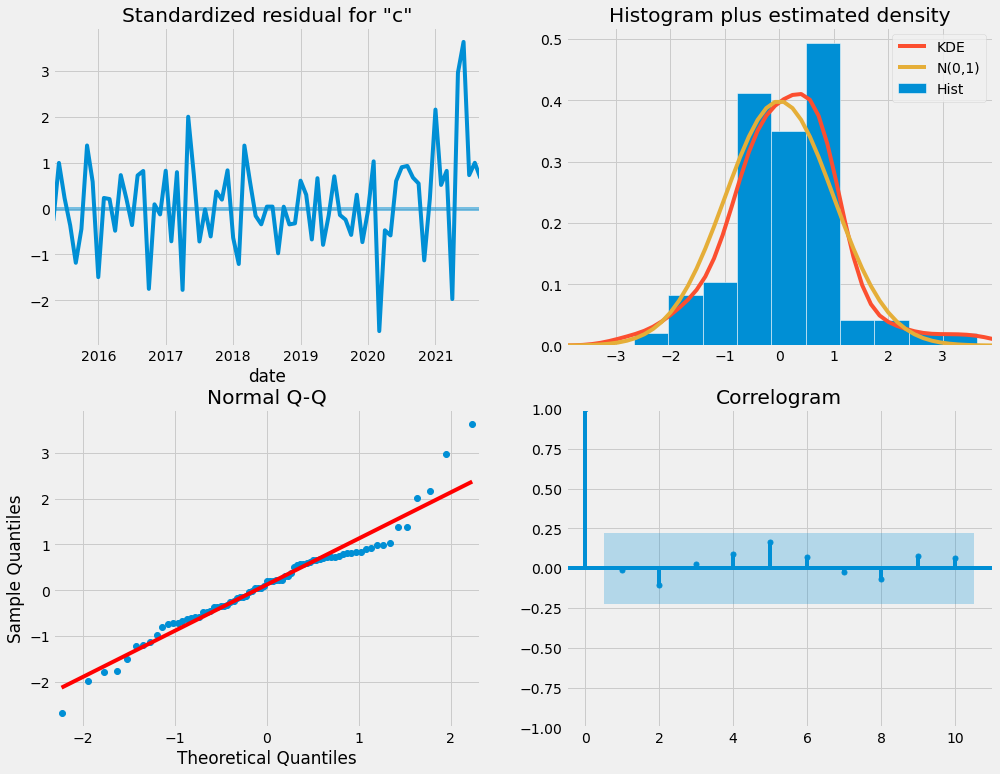

In [40]:
mod = sm.tsa.statespace.SARIMAX(df_final.conso_corri,
                                order=(0, 1, 2),
                                seasonal_order=(0, 1, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

results.plot_diagnostics(figsize=(15, 12))
#plt.savefig('paramesami.jpg', dpi=1200, bbox_inches='tight')
plt.show()

**Observation :**
- On constate qu'il n'y a pas d'autocorrélation dans les résidus et qu'ils suivent une loi normale ce qui valide notre modèle de regréssion.

In [41]:
#Test de Shapiro-Wilk
from scipy.stats import shapiro
shapiro(results.resid)[1]

3.376464406477141e-18

**Observation :**
- La distribution de nos résidus semble suivre une loi normale. On vérifie cela avec un test de Shapiro-Wilk se basant sur les hypothèses suivantes :

- - H0 : Il est peu probable que la distribution de nos résidus suive une loi normale
- - H1 : Il est probable que la distribution de nos résidus suive une loi normale
- La p-value est inférieure à 0.05. On peut donc rejeter l'hypothèse H0 selon laquelle il est peu probable que la distribution de nos résidus suive un loi normale.


### Prediction de la demande en électricité sur les 12 prochain mois méthode SARIMA

In [42]:
sarima_pred = SARI.get_forecast(12)

# Création d'un dataframe contenant la valeur et l'intervalle de confiance
prediction = pd.DataFrame(
               {'prediction': sarima_pred.predicted_mean,
                'conf_inf': [val[0] for val in sarima_pred.conf_int(alpha=0.05)],
                'conf_sup': [val[1] for val in sarima_pred.conf_int(alpha=0.05)]
               }, 
               index= pd.date_range(df_final.conso_corri.index.max(), periods=12, freq='M'))

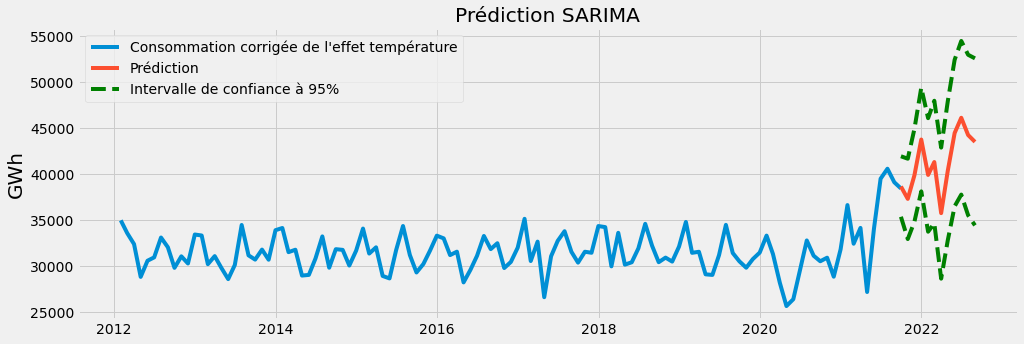

In [43]:
# Affichage de la prédiction
plt.figure(figsize=(15,5))
plt.plot(df_final.conso_corri, label="Consommation corrigée de l'effet température")
plt.plot(prediction['prediction'], label='Prédiction')
plt.plot(prediction['conf_sup'], label='Intervalle de confiance à 95%', color='g', linestyle='--')
plt.plot(prediction['conf_inf'], label='', color='g', linestyle='--')
plt.ylabel("GWh", fontsize=20)

plt.legend()

plt.title('Prédiction SARIMA')
#plt.savefig('pred_sami.jpg', dpi=1200, bbox_inches='tight')
plt.show()

### 3. 2.1 **Analyse à postériori des 3 modèles SARIMA**

#### Analyse à postériori Modèle I

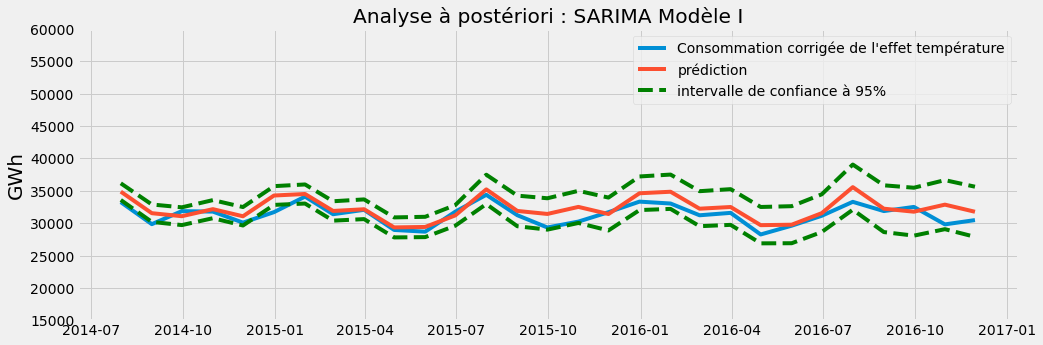

In [44]:
# Création du première modèle
sarima2_model = sm.tsa.statespace.SARIMAX(np.asarray(train1), 
                        order=(0,1,2), 
                        seasonal_order=(0,1,2,12), 
                        enforce_invertibility=False, 
                        enforce_stationarity=False)

sarima2_res = sarima2_model.fit()

# Prédiction
sarima2_pred = sarima2_res.get_forecast(29)

# Création du df contenant la valeur et l'intervalle de confiance
sarima2_pred = pd.DataFrame(
               {'prediction': sarima2_pred.predicted_mean,
                'conf_inf': [val[0] for val in sarima2_pred.conf_int(alpha=0.05)],
                'conf_sup': [val[1] for val in sarima2_pred.conf_int(alpha=0.05)]
               }, 
               index= test1.index)


plt.figure(figsize=(15,5))
plt.ylim((15000,60000))

plt.plot(test1, label="Consommation corrigée de l'effet température")

plt.plot(sarima2_pred['prediction'], label='prédiction')
plt.plot(sarima2_pred['conf_inf'], label='intervalle de confiance à 95%', color='g', linestyle='--')
plt.plot(sarima2_pred['conf_sup'], label='', color='g', linestyle='--')
plt.ylabel("GWh", fontsize=20)

plt.legend()

plt.title('Analyse à postériori : SARIMA Modèle I')
#plt.savefig('samira_model_1.jpg', dpi=1200, bbox_inches='tight')
plt.show()

**Observation :**
- La prédiction pour 2014-2017 avec la méthode SARIME est relativement fidèle aux données réelles. 

In [45]:
print('\nTEST DE JUNG-BOX - (Test de blancheur)\n\nRetard : p-value')
for elt in np.arange(3,29,3):
    print('{} : {}'.format(elt, acorr_ljungbox(sarima2_res.resid, lags=elt).mean()[1]))


TEST DE JUNG-BOX - (Test de blancheur)

Retard : p-value
3 : 0.9452783233134593
6 : 0.9612422778340086
9 : 0.9736601158175241
12 : 0.9329717125881639
15 : 0.8559800088569396
18 : 0.8340749859087357
21 : 0.8375549239902513
24 : 0.8504569442576795
27 : 0.8645732690511367


**Observation :**
- H0 il n'y a pas d'autocorrelation des erreurs d'order 1 à r
- H1 il y a d'autocorrelation des erreurs d'order 1 à r
- Nous avons un P-value supérieur à 5% donc H0 n'est pas rejeté au niveau de 5%.

In [46]:
RMSE_S = round(sqrt(mean_squared_error(test1, sarima2_pred['prediction'])),2)
MAPE_S = np.mean(np.abs((test1 - sarima2_pred['prediction']) / test1)) * 100

print ("RMSE1:", RMSE_S)
print ("MAPE1:", MAPE_S)

RMSE1: 1335.92
MAPE1: 3.4978236927206594


**Observation :**
- Le première modèle SARIMA a obtenu une **RMSE de 1335.92** et une **MAPE de 3.50**.

#### Analyse à postériori Modèle II SAMIRA

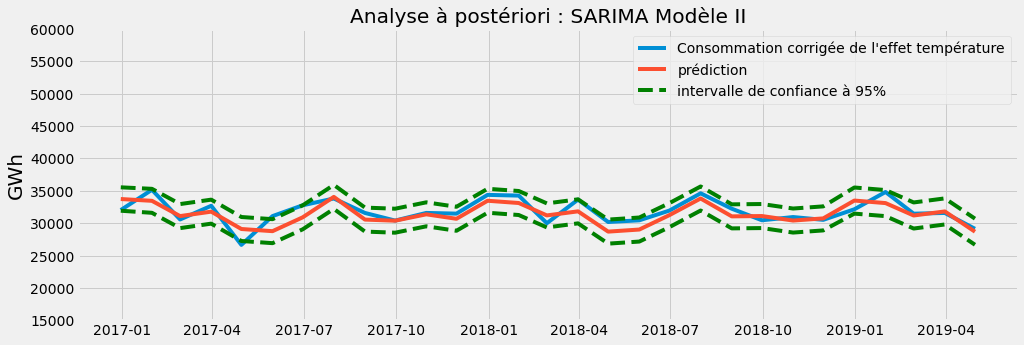

In [47]:
# Création du modèle 2
sarima_model_2 = sm.tsa.statespace.SARIMAX(np.asarray(train2), 
                        order=(0,1,2), 
                        seasonal_order=(0,1,2,12), 
                        enforce_invertibility=False, 
                        enforce_stationarity=False)

sarima_res_2 = sarima_model_2.fit()

# Prédiction
sarima_pred_2 = sarima_res_2.get_forecast(29)

# Création du df contenant la valeur et l'intervalle de confiance
sarima_pred_2 = pd.DataFrame(
               {'prediction': sarima_pred_2.predicted_mean,
                'conf_inf': [val[0] for val in sarima_pred_2.conf_int(alpha=0.05)],
                'conf_sup': [val[1] for val in sarima_pred_2.conf_int(alpha=0.05)]
               }, 
               index= test2.index)


plt.figure(figsize=(15,5))
plt.ylim((15000,60000))

plt.plot(test2, label="Consommation corrigée de l'effet température")

plt.plot(sarima_pred_2['prediction'], label='prédiction')
plt.plot(sarima_pred_2['conf_inf'], label='intervalle de confiance à 95%', color='g', linestyle='--')
plt.plot(sarima_pred_2['conf_sup'], label='', color='g', linestyle='--')
plt.ylabel("GWh", fontsize=20)

plt.legend()

plt.title('Analyse à postériori : SARIMA Modèle II')
#plt.savefig('samira_model_2.jpg', dpi=1200, bbox_inches='tight')
plt.show()

**Observation :**
- La prédiction pour 2017-2019 avec la méthode SARIME est relativement fidèle aux données réelles.

In [48]:
print('\nTEST DE JUNG-BOX - (Test de blancheur)\n\nRetard : p-value')
for elt in np.arange(3,29,3):
    print('{} : {}'.format(elt, acorr_ljungbox(sarima_res_2.resid, lags=elt).mean()[1]))


TEST DE JUNG-BOX - (Test de blancheur)

Retard : p-value
3 : 0.8588251807383673
6 : 0.917733090795502
9 : 0.9444617368451801
12 : 0.9460664394319634
15 : 0.9082617195356032
18 : 0.9058910426654688
21 : 0.9132690595773816
24 : 0.9193624622066677
27 : 0.9246950575907964


**Observation :**
- H0 il n'y a pas d'autocorrelation des erreurs d'order 1 à r
- H1 il y a d'autocorrelation des erreurs d'order 1 à r
- Nous avons un P-value supérieur à 5% donc H0 n'est pas rejeté au niveau de 5%.

In [49]:
RMSE_S_2 = round(sqrt(mean_squared_error(test2, sarima_pred_2['prediction'])),2)
MAPE_S_2 = np.mean(np.abs((test2 - sarima_pred_2['prediction']) / test2)) * 100

print ("RMSE2:", RMSE_S_2)
print ("MAPE2:", MAPE_S_2)

RMSE2: 1217.38
MAPE2: 3.2501570492537364


**Observation :**
- Le deuxieème modèle SARIMA a obtenu une **RMSE de 1217.38** et une **MAPE de 3.25**.

#### Analyse à postériori Modèle III SAMIRA

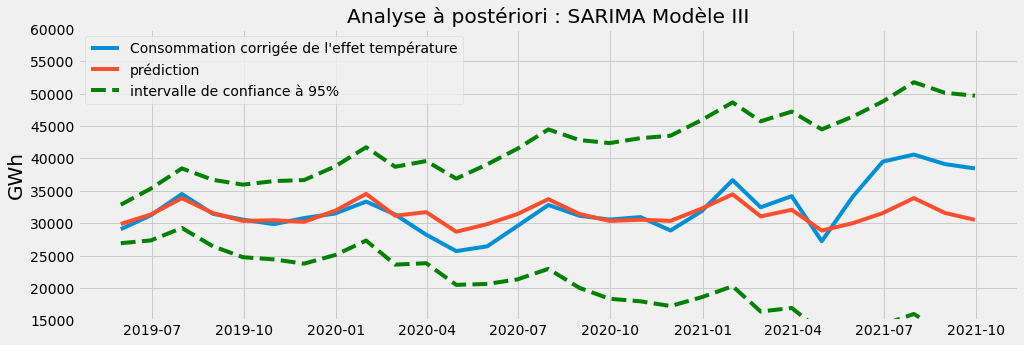

In [50]:
# Création du modèle 3
sarima_model_3 = sm.tsa.statespace.SARIMAX(np.asarray(train3), 
                        order=(0,1,2), 
                        seasonal_order=(0,1,2,12))

sarima_res_3 = sarima_model_3.fit()

# Prédiction
sarima_pred_3 = sarima_res_3.get_forecast(29)

# Création du df contenant la valeur et l'intervalle de confiance
sarima_pred_3 = pd.DataFrame(
               {'prediction': sarima_pred_3.predicted_mean,
                'conf_inf': [val[0] for val in sarima_pred_3.conf_int(alpha=0.05)],
                'conf_sup': [val[1] for val in sarima_pred_3.conf_int(alpha=0.05)]
               }, 
               index= test3.index)


plt.figure(figsize=(15,5))
plt.ylim((15000,60000))

plt.plot(test3, label="Consommation corrigée de l'effet température")

plt.plot(sarima_pred_3['prediction'], label='prédiction')
plt.plot(sarima_pred_3['conf_inf'], label='intervalle de confiance à 95%', color='g', linestyle='--')
plt.plot(sarima_pred_3['conf_sup'], label='', color='g', linestyle='--')
plt.ylabel("GWh", fontsize=20)

plt.legend()

plt.title('Analyse à postériori : SARIMA Modèle III')
#plt.savefig('samira_model_3.jpg', dpi=1200, bbox_inches='tight')
plt.show()

**Observation :**
- La prédiction pour 2019-2021 avec la méthode SARIME n'est pas fidèle aux données réelles. la méthode SARIMA semble  prendre en compte les impacts saisonniers (pics et creux) mieux que la méthode Holt-Winters.

In [51]:
print('\nTEST DE JUNG-BOX - (Test de blancheur)\n\nRetard : p-value')
for elt in np.arange(3,29,3):
    print('{} : {}'.format(elt, acorr_ljungbox(sarima_res_3.resid, lags=elt).mean()[1]))


TEST DE JUNG-BOX - (Test de blancheur)

Retard : p-value
3 : 0.8203655744141072
6 : 0.8319436796651768
9 : 0.8700136481367482
12 : 0.8169163031753688
15 : 0.6720694589771697
18 : 0.5888409148016571
21 : 0.548728041779445
24 : 0.5392205742929924
27 : 0.5498694740738316


**Observation :**
- H0 il n'y a pas d'autocorrelation des erreurs d'order 1 à r
- H1 il y a d'autocorrelation des erreurs d'order 1 à r
- Nous avons un P-value supérieur à 5% donc H0 n'est pas rejeté au niveau de 5%.

In [52]:
RMSE_S_3 = round(sqrt(mean_squared_error(test3, sarima_pred_3['prediction'])),2)
MAPE_S_3 = np.mean(np.abs((test3 - sarima_pred_3['prediction']) / test3)) * 100

print ("RMSE3:", RMSE_S_3)
print ("MAPE3:", MAPE_S_3)

RMSE3: 3225.0
MAPE3: 6.265361352971718


**Observation :**
- Le troisième modèle SARIMA a obtenu une **RMSE de 3225** et une **MAPE de 6.26**.

**Observation :**

- On observe que le meilleur modèle est le modèle 2 avec une **RMSE de 1217,38 et MAPE de 2,25**, suivi par le modèle 1.
- On a pu observer que le modèle 3 a plus de problème pour predire le forte baise et hause de comsommation pendant les années 2020 et 2021.

In [53]:
# On va calculer la mayenne de MAPE des 3 modèle SARIME
MAPE_Sarima_mean = round((MAPE_S + MAPE_S_2 + MAPE_S_3)/3,2)
MAPE_Sarima_mean

4.34

**Observation :**
- On obtient un erreur absolue moyenne en pourcentage égale à 4, 34% avec le modèle SARIME

> ***Comparaison des prédictions***

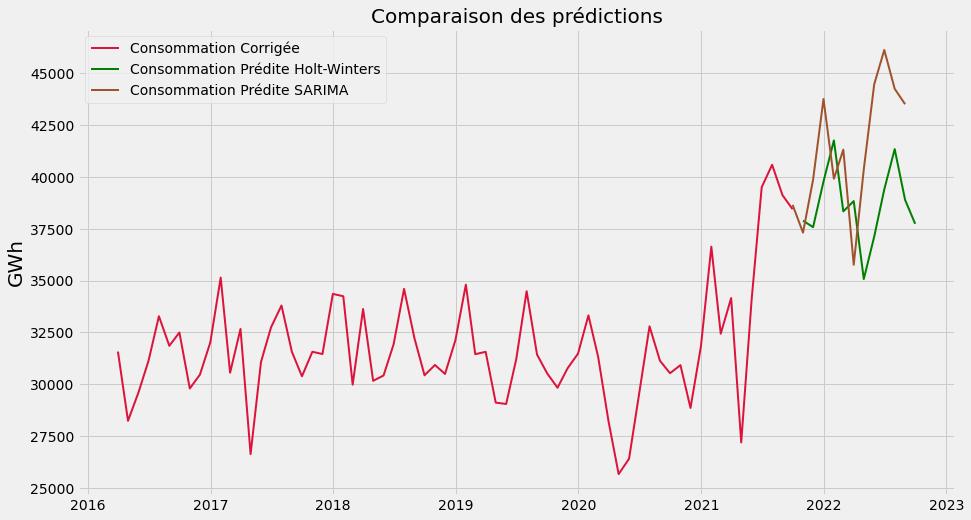

In [54]:
# Prédictions des deux modèles:
plt.plot(df_final["conso_corri"][50:], color="crimson", label="Consommation Corrigée", linewidth=2)
plt.plot(pred, color="green", label="Consommation Prédite Holt-Winters", linewidth=2)
plt.plot(prediction['prediction'], color="sienna", label="Consommation Prédite SARIMA", linewidth=2)

plt.title("Comparaison des prédictions", fontsize=20), plt.ylabel("GWh", fontsize=20), plt.legend(loc="best")
#plt.savefig('compare.jpg', dpi=1200, bbox_inches='tight')
plt.show()

**Conclusion :**

> > Les prévisions par la méthode de lissage exponentiel Holt-Winters et SARIMA sont globalement satisfaisantes, avec l’erreur absolue moyenne en pourcentage **égale à 4,34%** pour le modèle **SRIMA** et **égale à 3,96%** pour le modèle **Holt-Winters**. Par ailleurs, le modèle Holt-Winters sera retenu prioritairement pour prédire la consommation d’électricité. Il sera plus performant et plus robuste dans des prévisions devant prendre en compte de forts impacts saisonniers.